#### Using PRAW (Python Reddit API Wrapper) 

I found several restrictions in using the web API by Reddit described in the GA video.

    1. There is a limit of 1000 posts max you can scrap.
    2. Each GET request will only yield about 25 posts.
    3. The time required between GET requests is significant, especially so when the number of posts scrapped increases.
    
After some research online, I found PRAW (Python Reddit API Wrapper https://praw.readthedocs.io/en/latest/#), which is a utility to facilitate scrapping of Reddit posts using Python instead of HTML GET requests.

After some evaluation, I decided to to use PRAW for scrapping as it is not restricted by the above mentioned limitations. Also, using Python scripts will allow me to deploy them in servers as background threads, scrapping posts at pre-defined intervals.

#### Using a RDBMS

I've chosen to store the scrapped posts in a RDBMS instead of a flat CSV file for the following reasons:

    1.There is a fair amount of data to manage and pre-process.
    2.Storage efficiencies.
    3.The ability to store and organize pre-processing data i.e. tokens, meaningful words for modeling later.
    4.The amount of data i.e. number posts will increase from day to day.
    5.The ability to query and update the data efficiently.
    
As such, I subscribed to AWS's Free Tier account and created an instance of a MySQL database. When selecting options for the database, it is important to allow for public accessibility. This will allow my Python scripts to communicate with the MySQL database. I also had to open the port 3306 in the VPC security group, as this is the default port MySQL database uses to communicate with its clients.

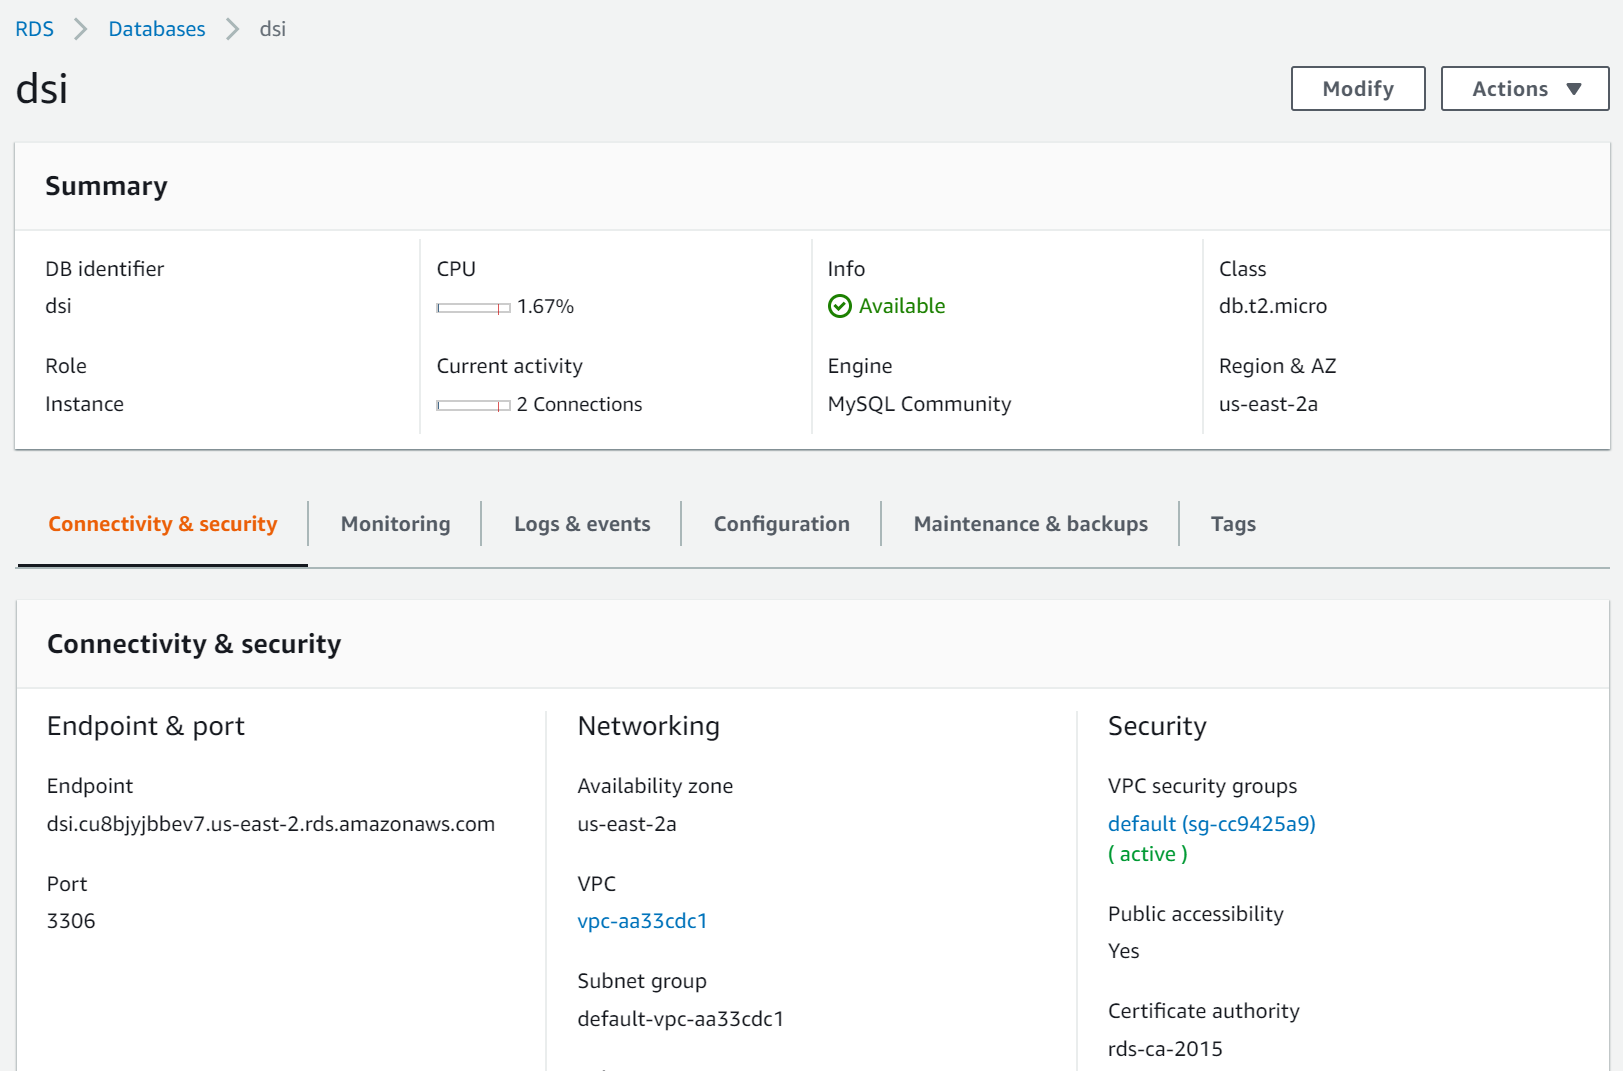

After the MySQL database is up and running, I created the table required to store the Reddit posts. Using the MYSQL Workbench tool, I connected to the database and created the posts table with the below specifications.

name - A unqiue identifer of each post
subreddit - The sub-reddit the post belongs to
title - Title of the post
selftext - Text within the post
created - Timestamp on the creation of the post
batch_id - An identifier for the batch from which the post was scrapped

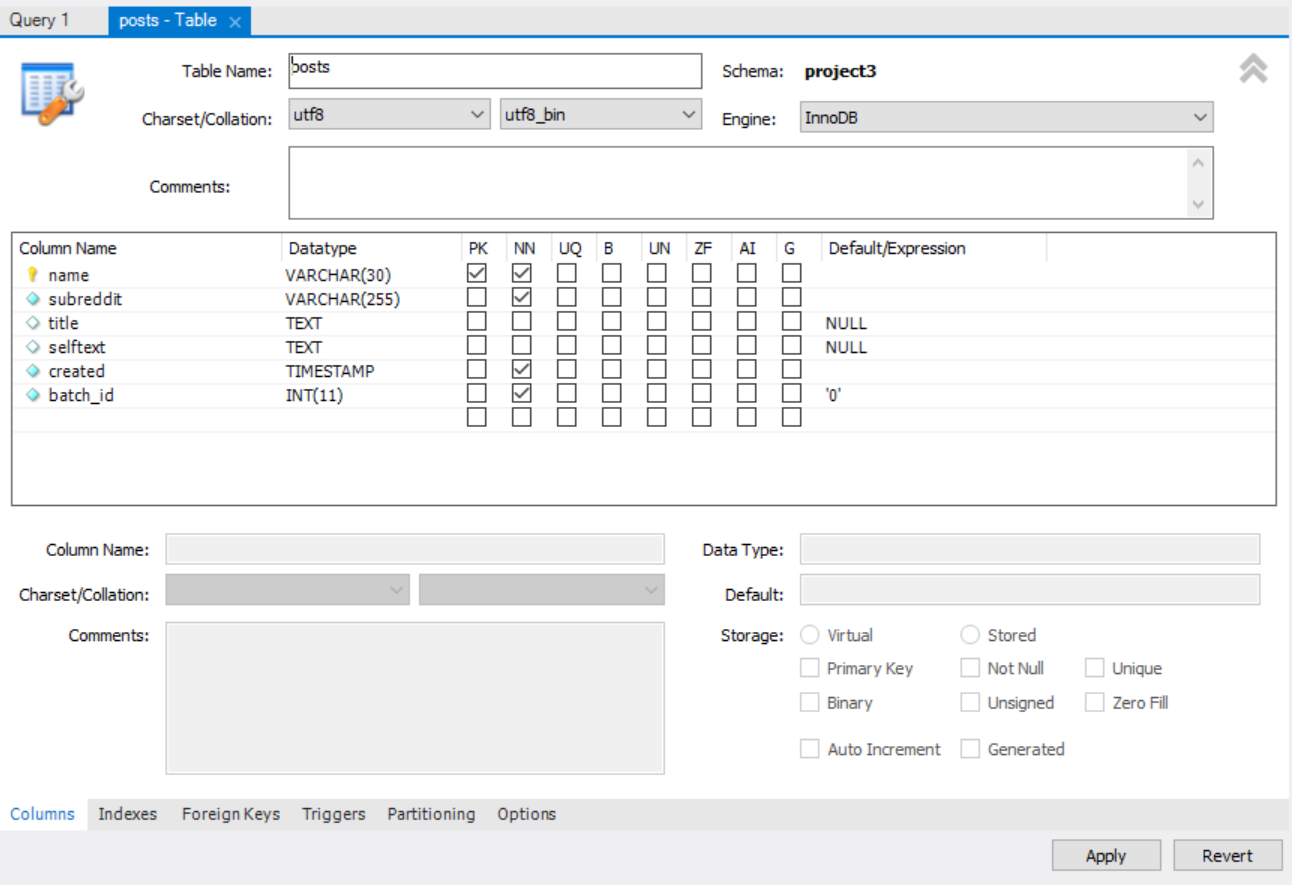

Subsequently, I created a series of Python modules and classes to facilitate the scrapping of Reddit posts. The brief structure of the these modules are as follows:

- utils - Main utility scripts for Reddit scrapping, preprocessing and NLP
- utils.model - Python classes that model the database tables
- utils.aws - Python modules that interface with the AWS services and RDBMS

utils.RedditScrapper.py is the main script to perform the scrapping. There are 3 parts to its jobs

#### 1. Scrapping from Reddit

It connects to Reddit via PRAW and makes requests for posts from a sub-reddit. There are a variety of parameters to configure the query (refer to API documentation). But for purpose of this project, I will only need the 'new' parameter to retrieve the lastest posts. 

In [ ]:
praw.Reddit(client_id='decGUQHbZSwTxA', client_secret='ePMxrPWEiouDDV07dZiVpJ08y4g', user_agent='project3')

...

sr = reddit.subreddit(subreddit)

... 

posts = sr.new(limit=limit)

#### 2. Check for Unique Posts

After retrieving the posts, I have to check that these posts are indeed unique, that they don't already existing in my collection. As I've stored the posts in a RDBMS, this is a simple query for the 'name' field from the posts table.

In [ ]:
AWSDB.get_reddit_post_names()

#### 3. Persist to RDBMS

After removing all duplicate posts, I proceed to persist the unique posts in the database using the AWS RDBMS interface I've created. 

In [ ]:
AWSDB.insert_reddit_posts(list(current_posts.values()))

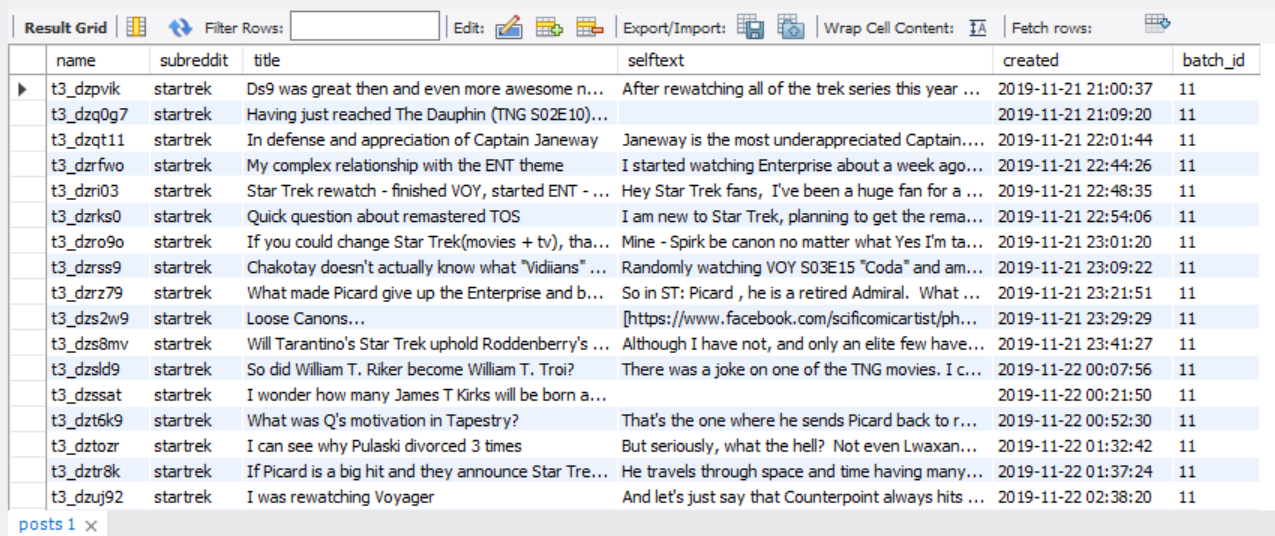

#### Class Hierarchies

Within the utils.model.post module, the RedditPost and NLPPost classes model the 'posts' and 'posts_nlp' database tables respectively. The 'posts' table contains posts scrapped from Reddit, and the 'posts_nlp' table stores the pre-processing done for NLP on thoses posts.

NLPPost inherits from RedditPost, which in turn is the child of the Post parent class. Both NLPPost and RedditPost inherits the 'name' and 'title' instance class variables from the parent class Post.  For details on the specifications, please refer the documentation within the Python code.

Post -> RedditPost -> NLPPost


In [ ]:
class Post:
    ...
    
class RedditPost(Post):
    ...
    

class NLPPost(RedditPost):
    ...

#### Abstraction of AWS RDS

The dircetory utils.aws contains scripts pertaining to access to the AWS MySQL database.  AWSDB.py contains accessor methods that facilitate the interface with the underlying database. It is a layer of abstraction to future-proof against any change in database. If in future, under some circumstances, I need to change the RDBMS MySQL to a OODBMS like DynamoDB, I just need to implement the accessor methods in AWSDB in a DynamoDB specific module like MySQLDB.py. 


Client (.e.g. NLPUtils.py) 
    -> AWSDB.py (Abstraction layer) 
        -> MySQLDB.py (Database specific implementation) 
            -> MySQL database on AWS


#### RedditScrapper.py

Below is a listing of code in RedditScrapper.py. The intention is to run the script as a background thread or task  scrapping posts at a pre-defined interval.


In [2]:
import praw

from pprint import pprint

from utils.model.post import RedditPost

from utils.aws import AWSDB


# Establish a connection to Reddit via the PRAW wrapper api
reddit = praw.Reddit(client_id='decGUQHbZSwTxA', client_secret='ePMxrPWEiouDDV07dZiVpJ08y4g', user_agent='project3')


# Scrap posts by sub reddit and limit the number of posts retrieved
def scrap_posts(subreddit, limit):

    # Create an instance of the sub reddit
    sr = reddit.subreddit(subreddit)

    print(f'Scrapping {limit} posts from subreddit ' + subreddit)

    # Retrieve most recent posts specified by argument limit
    posts = sr.new(limit=limit)

    # Get existing post names to check for duplicate posts
    existing_posts = AWSDB.get_reddit_post_names()
    current_posts = {}

    scrap_count = 0

    for post in posts:

        scrap_count += 1

        # pprint(vars(post))

        # Check that post is distinct
        if (post.name in current_posts.keys()) or (post.name in existing_posts):

            print('Duplicate post found: ' + post.name)

        else:

            # Create reddit post
            rd_post = RedditPost(post.name, post.subreddit_name_prefixed[2:], post.title, post.selftext,
                                 post.created_utc, batch_id=0)

            current_posts[post.name] = rd_post

            print(f'Scrapping post #{scrap_count}: {post.name}')

    print(f'Scrapped {scrap_count} posts, unique posts = {len(current_posts)}')

    # Save scrapped posts in AWS RDS Mysql
    AWSDB.insert_reddit_posts(list(current_posts.values()))

scrap_posts('startrek', 300)



Scrapping 300 posts from subreddit startrek
sql query failed: Unread result found
Scrapping post #1: t3_ehfhg7
Scrapping post #2: t3_ehfh9q
Scrapping post #3: t3_ehdswp
Scrapping post #4: t3_ehdpfx
Scrapping post #5: t3_ehdo4f
Scrapping post #6: t3_ehd395
Scrapping post #7: t3_ehcih1
Scrapping post #8: t3_ehc3l7
Scrapping post #9: t3_ehbedl
Scrapping post #10: t3_ehb200
Scrapping post #11: t3_ehaspp
Scrapping post #12: t3_eha3pq
Scrapping post #13: t3_eh9yn1
Scrapping post #14: t3_eh9d5i
Scrapping post #15: t3_eh9cyd
Scrapping post #16: t3_eh8xwt
Scrapping post #17: t3_eh83c3
Scrapping post #18: t3_eh72l9
Scrapping post #19: t3_eh6u60
Scrapping post #20: t3_eh60au
Scrapping post #21: t3_eh4nfh
Scrapping post #22: t3_eh4ifj
Scrapping post #23: t3_eh4hzk
Scrapping post #24: t3_eh4hzf
Scrapping post #25: t3_eh44mf
Scrapping post #26: t3_eh39rg
Scrapping post #27: t3_eh2stc
Scrapping post #28: t3_eh2bm7
Scrapping post #29: t3_eh287p
Scrapping post #30: t3_eh1deg
Scrapping post #31: t3_eh19

121  posts inserted successfully into database
